In [1]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# === Path setup ===
SOURCE = Path("/kaggle/input/breast-histopathology-patches/breast-histopathology-images")
WORKING = Path("/kaggle/working")
YES_DIR = WORKING / "data/yes"
NO_DIR = WORKING / "data/no"

YES_DIR.mkdir(parents=True, exist_ok=True)
NO_DIR.mkdir(parents=True, exist_ok=True)

# === Collect images ===
yes_images = []
no_images = []

for folder in SOURCE.iterdir():
    if (folder / "1").exists():
        yes_images.extend((folder / "1").glob("*.png"))
    if (folder / "0").exists():
        no_images.extend((folder / "0").glob("*.png"))

print(f"✅ Found {len(yes_images)} cancer and {len(no_images)} non-cancer images")

# === Sample 50k each ===
yes_sample = random.sample(yes_images, min(50000, len(yes_images)))
no_sample = random.sample(no_images, min(50000, len(no_images)))

for img in yes_sample:
    shutil.copy(img, YES_DIR / img.name)
for img in no_sample:
    shutil.copy(img, NO_DIR / img.name)

print("✅ Copied 50k images for each class")

# === Split into train and val ===
train_path = WORKING / "data/train"
val_path = WORKING / "data/val"

for split in ['train', 'val']:
    for label in ['yes', 'no']:
        os.makedirs(WORKING / "data" / split / label, exist_ok=True)

def split_and_copy(images, label):
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    for img in train_imgs:
        shutil.copy(img, train_path / label / img.name)
    for img in val_imgs:
        shutil.copy(img, val_path / label / img.name)

split_and_copy(list(YES_DIR.glob("*.png")), "yes")
split_and_copy(list(NO_DIR.glob("*.png")), "no")

print("✅ Dataset preparation complete.")


✅ Found 78786 cancer and 198738 non-cancer images
✅ Copied 50k images for each class
✅ Dataset preparation complete.


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths
TRAIN_DIR = "/kaggle/working/data/train"
VAL_DIR = "/kaggle/working/data/val"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

# Check if paths exist (debug step)
import os
print("✅ TRAIN_DIR exists:", os.path.exists(TRAIN_DIR))
print("✅ VAL_DIR exists:", os.path.exists(VAL_DIR))

# Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)
val_data = val_gen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)

# Build model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint("densenet121_idc.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
]

# Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)


# ✅ Ensure model is saved regardless of validation improvements
model.save("densenet121_idc_final.h5")
print("✅ Training complete. Model saved as both:")
print(" - Best validation: 'densenet121_idc.h5'")
print(" - Final model:     'densenet121_idc_final.h5'")


2025-09-10 07:58:01.244251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757491081.438951      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757491081.492881      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TRAIN_DIR exists: True
✅ VAL_DIR exists: True
Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


I0000 00:00:1757491096.976833      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1757491196.625066      72 service.cc:148] XLA service 0x7fbe88007a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757491196.626025      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757491205.696530      72 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757491294.198429      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7859 - loss: 0.5811
Epoch 1: val_accuracy improved from -inf to 0.86710, saving model to densenet121_idc.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1079s 356ms/step - accuracy: 0.7859 - loss: 0.5810 - val_accuracy: 0.8671 - val_loss: 0.4213 - learning_rate: 1.0000e-04
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8597 - loss: 0.4345
Epoch 2: val_accuracy improved from 0.86710 to 0.88505, saving model to densenet121_idc.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 851s 340ms/step - accuracy: 0.8597 - loss: 0.4345 - val_accuracy: 0.8850 - val_loss: 0.3907 - learning_rate: 1.0000e-04
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8746 - loss: 0.4112
Epoch 3: val_accuracy improved from 0.88505 to 0.89440, saving model to densenet121_idc.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 854s 342ms/step - accuracy: 0.8746 - loss: 0.4112 - val_accuracy: 0.8944 - val_loss: 0.3774 - learning_rate: 1.0000e-04
Epoch 4/15
2500/2

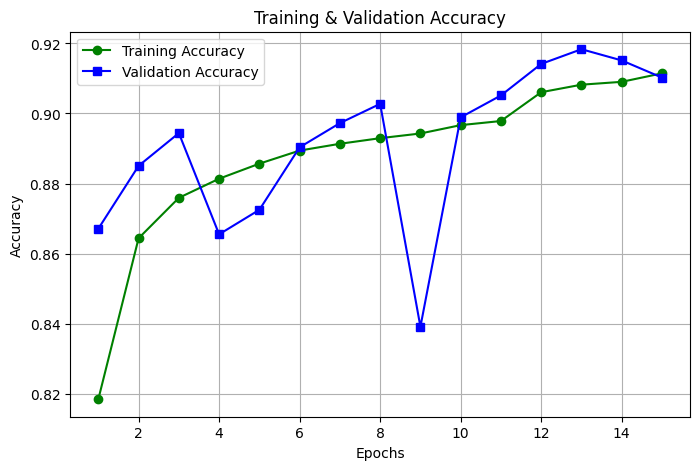

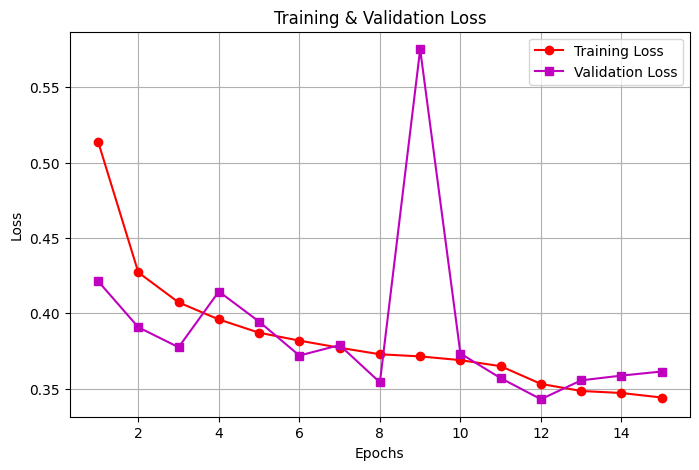

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'g-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-s', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'r-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'm-s', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_training_curves(history)
plt.savefig("accuracy_plot.png")
plt.savefig("loss_plot.png")
